<a href="https://colab.research.google.com/github/gmanfunkflex5500/nyc_taxi_filter/blob/web_app/Updating_dispatcher_and_vehicle_dictionaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Head
+ Introduction



```
This project uses the Google Cloud Platform to perform an analysis on NYC's documented 
shared rides from 2018. 

The Goal of this project is to create an analysis that counts the number of 
wheelchair accessible (WAV), battery electric (BEV), and shared ride trips from 
New York's three airports for the week of Jan 8th-15th, 2018. 

This analysis will include comparisons of each major ride share company (Uber, Lyft, Juno) 
to each other as well as to the rest of the industry, as well as include daily aggregates.

This project will be used to produce a 1-page summary document of the findings, 
methodology, and limitations of this analysis.

Pickup location id's are taken from 
https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc

The id's are:
EWR = 1 
LGA = 138
JFK = 132

Data is from NYC Open Data https://data.cityofnewyork.us/Transportation/2018-For-Hire-Vehicles-Trip-Data/am94-epxh/

For future data keeping I would recommend tracking the first 8 digits of a 
vehicle's VIN number to rides, as those are not linked to models instead of 
individual cars. This will provide anonymity for drivers while increasing the 
accuracy of the data available by providing care make and model or each ride.

Additional note - the links in the project guidelines often have inappropriate spaces 
that redirect to an incomplete URL.
```



## connect to google drive to import/export files

In [0]:
# Connect to google drive to access data and sensitive info

from google.colab import drive

drive.mount('/content/drive')#/My Drive/Colab Notebooks')
root_path = 'gdrive/My Drive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# J. Garrett Frierson - Nov. 4th, 2019 - Brooklyn, NY
!pip install sodapy
!pip install bs4

In [0]:
# Importing relevant libraries

from sodapy import Socrata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import requests
import json

In [0]:
!ls "/content/drive/My Drive/Colab Notebooks/NYC airport trips jan 2018"

'Airport Report 2018-jan.ipynb'
 api_keys.json
 app_percent_of_app_trips.csv
 config.js
 config.json
 data_dictionary_trip_records_fhv.pdf
 date_dispatch_trip_details.csv
 Deliverables
 df.csv
 keys.json
 Lyft_jan8_2018.csv
 Lyft_jan8_2018.gsheet
 other_jan8_2018.csv
 other_jan8_2018.gsheet
 trips_by_day_and_dispatcher.csv
 trips_by_day_and_dispatcher.gsheet
 trips_by_day.csv
 trips_by_day.gsheet
 trip_totals_by_dispatcher.csv
 trip_totals_by_dispatcher.gsheet
 trip_totals_by_dispatcher_percent_of_all.csv
 Uber_jan8_2018.csv
 Uber_jan8_2018.gsheet
 Via_jan8_2018.csv
 Via_jan8_2018.gsheet


In [0]:
# load config.json that contains sensitive login information
with open('/content/drive/My Drive/Colab Notebooks/NYC airport trips jan 2018/config.json', 'r') as f:
  keyload = f.read()
  f.close()

keys = json.loads(keyload)['config']




#**IMPORTING & CLEANING DATA**




### Import the trip data
  Make modifiable for future web apps

In [0]:
# Importing trip data using NYC Open Data user info

client = Socrata("data.cityofnewyork.us", 
                 keys['APP_TOKEN'],
                 username=keys['username'],
                 password= keys["pwd"])

#results = client.get_metadata("am94-epxh")
results = client.get("am94-epxh", 
                     where="pickup_datetime between '2018-01-08T00:00:00.000' and '2018-01-16T00:00:00.000' AND pulocationid in (138, 132, 1)", 
                     limit=50000000)
len(results)

125542

In [0]:
# Converting data to dataframe

results_df = pd.DataFrame.from_records(results)

results_df.head()




,dispatching_base_num,pickup_datetime,dropoff_datetime,pulocationid,dolocationid,sr_flag
0,B00823,2018-01-08T00:00:00.000,2018-01-08T00:33:52.000,138,25,NaN
1,B00823,2018-01-08T00:00:00.000,2018-01-08T01:45:58.000,132,181,NaN
2,B02835,2018-01-08T00:00:03.000,2018-01-08T00:16:22.000,138,65,NaN
3,B02510,2018-01-08T00:00:10.000,2018-01-08T03:06:32.000,138,265,NaN
4,B02867,2018-01-08T00:00:10.000,2018-01-08T00:30:42.000,132,164,NaN


# Cleaning trip data

In [0]:
# Checking to make sure our dates as well as locations are properly filtered
print(results_df['pickup_datetime'].min(), results_df['pickup_datetime'].max(), "Locations = " + results_df.pulocationid.unique())

2018-01-08T00:00:00.000 2018-01-15T23:59:48.000 ['Locations = 138' 'Locations = 132' 'Locations = 1']


In [0]:
# Checking for null values
results_df.isna().any()

dispatching_base_num    False
pickup_datetime         False
dropoff_datetime        False
pulocationid            False
dolocationid             True
sr_flag                  True
dtype: bool

In [0]:
# Removing dolocationid as it is not relevant to this analysis
df_no_nan = results_df.drop('dolocationid', axis=1)
# Replacing NaN's with 0 for sr_flag (sharing indicator, 1 = shared, 0 = not shared)
df_no_nan = df_no_nan.fillna(0)

## Cleaning and aggregrating trip data


In [0]:
# joining our names onto our original dataframe
 
trip_df = df_no_nan#.join(dispatcher_df, on='dispatching_base_num')
#trip_df.head()


Adding ride time feature, cleaning dates, removing dropoff datetime

In [0]:
# Create a ride time feature
trip_df['ride_time'] = (pd.to_datetime(trip_df['dropoff_datetime']) - pd.to_datetime(trip_df['pickup_datetime']))

In [0]:
# Adding a trip counter to sum the total number of trips
trip_df['trip_count'] = 1
trip_df['sr_flag'] = trip_df['sr_flag'].astype(int)

# Changing pickup datetime to date only for aggregration
trip_df['pickup_datetime'] = pd.to_datetime(trip_df['pickup_datetime']).dt.date
trip_df.head()

# Dropping dropoff_datetime as it is not relevant to our query
trip_df = trip_df.drop('dropoff_datetime', axis=1)

In [0]:
cols = ['pickup_datetime','dispatching_base_num', 'sr_flag',
        'trip_count', 'pulocationid','ride_time']

trip_df = trip_df[cols]


In [0]:
trip_df.head()

,pickup_datetime,dispatching_base_num,sr_flag,trip_count,pulocationid,ride_time
0,2018-01-08,B00823,0,1,138,00:33:52
1,2018-01-08,B00823,0,1,132,01:45:58
2,2018-01-08,B02835,0,1,138,00:16:19
3,2018-01-08,B02510,0,1,138,03:06:22
4,2018-01-08,B02867,0,1,132,00:30:32


### Aggregrating trips to day and dispatcher

In [0]:
# Creating a ride_time table to be accessed if needed in future projects

ride_time = trip_df.drop(['sr_flag','trip_count', 'pulocationid'], axis = 1 )
ride_time['ride_time'] = ride_time['ride_time'].values.astype(np.int64)
ride_time = ride_time.groupby(['pickup_datetime', 'dispatching_base_num']).mean()
ride_time['ride_time'] = pd.to_timedelta(ride_time['ride_time'])
ride_time.head()


ride_time
pickup_datetime dispatching_base_num                
2018-01-08      B00236               01:03:33.500000
                B00254               01:28:01.704545
                B00445                      00:45:50
                B00446               01:52:45.333333
                B00477               00:31:39.916666

In [0]:
trip_count_df = trip_df.drop(['ride_time','pulocationid'], axis = 1).groupby(['pickup_datetime', 'dispatching_base_num']).sum()
trip_count_df.head()


sr_flag  trip_count
pickup_datetime dispatching_base_num                     
2018-01-08      B00236                      0           2
                B00254                      0          44
                B00445                      0           5
                B00446                      0           6
                B00477                      0          12

In [0]:
trip_count_df.describe()

,sr_flag,trip_count
count,480.00000,480.000000
mean,35.41875,261.545833
std,148.69254,581.160952
min,0.00000,1.000000
25%,0.00000,6.000000
50%,0.00000,120.000000
75%,24.00000,255.500000
max,1505.00000,5334.000000


# Import the vehicle data

In [0]:
# Importing vehicle info by dispatcher to approximate the total number of WAV and BEV
# taken from https://data.cityofnewyork.us/Transportation/For-Hire-Vehicles-FHV-Active/8wbx-tsch/data
client = Socrata("data.cityofnewyork.us", 
                 keys['APP_TOKEN'],
                 username=keys['username'],
                 password= keys["pwd"])

query = """
SELECT 
base_number, wheelchair_accessible, vehicle_vin_number
GROUP BY base_number, wheelchair_accessible, vehicle_vin_number
LIMIT 500000
"""

vehicle_client = Socrata("data.cityofnewyork.us", 
                 keys['APP_TOKEN'],
                 username=keys['username'],
                 password= keys["pwd"])

#results = client.get_metadata("am94-epxh")
vehicle_results = client.get("8wbx-tsch", query=query)
                             #select="base_number, wheelchair_accessible",
                             #where= "vehicle_year < 2019 AND veh IS NOT NULL",#"wheelchair_accessible IS NOT NULL",
                             #limit=10)
vehicle_results

[{'base_number': 'B03179', 'vehicle_vin_number': '1GNSKJKC6FR194528'},
 {'base_number': 'B01510', 'vehicle_vin_number': '1FADP5AU8EL507476'},
 {'base_number': 'B02990', 'vehicle_vin_number': '1GNSKHKC2JR143562'},
 {'base_number': 'B02682', 'vehicle_vin_number': 'JTMBFREV1HJ119942'},
 {'base_number': 'B02869', 'vehicle_vin_number': '1HGCR2F32EA175241'},
 {'base_number': 'B02682', 'vehicle_vin_number': '4T1BF1FKXHU411847'},
 {'base_number': 'B02887', 'vehicle_vin_number': '4T1BF1FK2GU214637'},
 {'base_number': 'B02870', 'vehicle_vin_number': '5TDJZRFH0HS378291'},
 {'base_number': 'B02880', 'vehicle_vin_number': '1N4AL3AP7DN581939'},
 {'base_number': 'B02879', 'vehicle_vin_number': '2HKRW2H87JH616777'},
 {'base_number': 'B02872', 'vehicle_vin_number': '1FADP3K28FL363124'},
 {'base_number': 'B02970', 'vehicle_vin_number': '2C3CCAGG5FH854083'},
 {'base_number': 'B02884', 'vehicle_vin_number': '1C4RJFAG0CC128728'},
 {'base_number': 'B01315', 'vehicle_vin_number': '5TDJKRFH9GS253373'},
 {'bas

## Clean the vehicle data 
and implement counts of WAV and BEV's

Count all WAVs from our database

In [0]:
# Create a dataframe of our vehicles and make WAV either a 1 (WAV) or 0 (not)

vh_df = pd.DataFrame(data=vehicle_results)
vh_df = vh_df.fillna(0)
vh_df['wheelchair_accessible'] = vh_df['wheelchair_accessible'].replace('WAV', 1)
vh_df.describe()

,wheelchair_accessible
count,115621.000000
mean,0.011053
std,0.104553
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [0]:
# Some dispatchers do not have a vehicle associated in this database
vh_df.loc[vh_df['base_number'] == 'B00236']

,base_number,vehicle_vin_number,wheelchair_accessible


Remove single vehicle identifiers to focus only on make and models

In [0]:
# The last 8 numbers of a vehicles vin number relate to the year and factory they were made in 
# and individual vehicle identificaiton. 
# The first 8 numbers describe the vehicle model and details.
# We are only keeping the first 8 digits so we can group cars by make and model

vh_df['vehicle_vin_number'] = vh_df['vehicle_vin_number'].str[:8]

In [0]:
# Adding a single value for each vehicle to be summed when grouping, giving us the count
# of each vehicle in each dispatcher's fleet.
vh_df['vehicle_count'] = 1
vh_df['vehicle_count']

0         1
1         1
2         1
3         1
4         1
         ..
115616    1
115617    1
115618    1
115619    1
115620    1
Name: vehicle_count, Length: 115621, dtype: int64

In [0]:
# Grouping our vehicles by base number and vin number (make model)
vh_grouped_df = vh_df.groupby(['base_number','vehicle_vin_number']).sum()
vh_grouped_df


wheelchair_accessible  vehicle_count
base_number vehicle_vin_number                                      
B00001      1GYS4GKJ                                0              2
            1GYS4HKJ                                0              2
            2G61U5S3                                0             16
            3FADP0L3                                0              1
            WBA7E4C5                                0              4
...                                               ...            ...
B03258      5TDKZ3DC                                0              2
            5TDYK3DC                                0              2
            5TDYZ3DC                                0              1
            NJ040D                                  0              1
B90139      1FTYR2CM                                0              1

[26232 rows x 2 columns]

### Create a dataframe of vehicle fuel types

In [0]:
# Pull out distinct vehicle types to send to nhtsa.dot.gov api to get vehicle details
# API connection at https://vpic.nhtsa.dot.gov/api/vehicles/DecodeVinValues/

import ast

def vehicle_details_retriever(model):
  vh_dict = {}
  url1 = 'https://vpic.nhtsa.dot.gov/api/vehicles/DecodeVinValues/'
  url2 = '?format=json'

  
  api_connect = url1 + model + url2;    # Create our api url to pull vehicle details
  r2 = requests.get(api_connect);      # Connect to api and retrieve details
  r2.json()                     # parse into json
  u = json.dumps(r2.json()['Results'])
  # Create dict of vehicle details
  dict_u = ast.literal_eval(u.replace("[","").replace("]","")) 
  if 'FuelTypePrimary' in dict_u:
    x,y = dict_u['FuelTypePrimary'], dict_u['FuelTypeSecondary']
   # print(model, (x,y))    # uncomment for debugging 
    vh_dict[model] = (x,y)
  else:
   # print('NA')            # uncomment for debugging 
    vh_dict[model] = ('None', 'None')

  return vh_dict
  
  



In [0]:
from multiprocessing import Pool  # multiprocessing used to speed up this api query

with Pool(1) as p:
  vh_dict_list = p.map(vehicle_details_retriever,vh_df['vehicle_vin_number'].unique())

vh_dict_list

In [0]:
# Confirm our list of vehicles is the same number as our car values
print(len(vh_dict_list), len(vh_df['vehicle_vin_number'].unique()))


NameError: ignored

In [0]:
# Convert our vehicle info into a dataframe
vh_dict = {}
for vh in vh_dict_list:
  vh_dict.update(vh)


vh_dts_df = pd.DataFrame.from_dict(vh_dict, orient='index', columns=['fuel_type_1', 'fuel_type_2'])
vh_dts_df.sample(10)


,fuel_type_1,fuel_type_2
1HGCP263,Gasoline,
1FM5K7DH,Gasoline,
JTMZF33V,Gasoline,
2LNHM82W,Gasoline,
3VWDX7AJ,Gasoline,
5FNYF6H9,Gasoline,
3GKALPEV,Gasoline,
JTHGL5EF,Gasoline,
JF2SJAJC,Gasoline,
5UXUJ3C5,Gasoline,


Edit our dataframe to focus solely on if a vehicle is a BEV

In [0]:
# Count the number of electric only vehicle types
vh_dts_df.loc[(vh_dts_df['fuel_type_1'] == 'Electric') & (vh_dts_df['fuel_type_2'] == '')].count()

fuel_type_1    26
fuel_type_2    26
dtype: int64

In [0]:
# Create a field that demarks if vehicle is BEV or no (0 = no, 1 = yes)
vh_dts_df['BEV'] = 0
vh_dts_df['BEV'].loc[(vh_dts_df['fuel_type_1'] == 'Electric') & (vh_dts_df['fuel_type_2'] == '')] = 1
vh_dts_df['BEV'].sum()  # Check that we hav the right amount of vehicles

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


26

In [0]:
bev_df = vh_dts_df.drop(['fuel_type_1', 'fuel_type_2'], axis=1).rename_axis('vehicle_vin_number')
bev_df.head()

,BEV
vehicle_vin_number,
1GNSKJKC,0
1FADP5AU,0
1GNSKHKC,0
JTMBFREV,0
1HGCR2F3,0


Combining BEV with our grouped vehicle dataframe


In [0]:
# Join our BEV column onto our table with other details for vehicle info

vh_fnl = vh_grouped_df.join(bev_df, 
                            how='left')  
# Multiplying BEV by vehicle count to accurately depict the total number of BEV's in 
# each fleet, similar to wheelchair accessible vehicles
vh_fnl['BEV'] = vh_fnl['BEV'] * vh_fnl['vehicle_count']
vh_fnl.loc[vh_fnl['BEV'] != 0]

wheelchair_accessible  vehicle_count  BEV
base_number vehicle_vin_number                                           
B00472      5YJSA1CN                                0              2    2
B00789      5YJXCAE2                                0              1    1
B01509      1G1ZB5E0                                0              1    1
B01899      5YJ3E1EA                                0              1    1
B02152      5YJ3E1EB                                0              1    1
...                                               ...            ...  ...
B03136      5YJ3E1EB                                0              4    4
            5YJSA1E2                                0              1    1
B03138      5YJSA1H1                                0              1    1
B03146      5YJXCBE2                                0              1    1
B03147      5YJ3E1EA                                0              1    1

[64 rows x 3 columns]

Create a table of dispatchers, with the probability of any given trip being a WAV or BEV

In [0]:
# Interestingly, only one of 3 Juno and Gett reigstered dispatch numbers have
# any cars registered to them
# Juno and Gett base numbers B02914 B02907 B02908
print(('B02907' in vh_fnl.index.unique()), "\n",
      ('B02908' in vh_fnl.index.unique()), "\n",
      ('B02914' in vh_fnl.index.unique()))

False 
 False 
 True


In [0]:
# Create a table of dispatchers with probability scores 
# for any given ride to be a WAV or BEV

dsptch_scores = vh_fnl.reset_index().drop('vehicle_vin_number', axis=1).groupby('base_number').sum()
dsptch_scores['BEV_Prob'] = (dsptch_scores['BEV'] / dsptch_scores['vehicle_count'])
dsptch_scores['WAV_Prob'] = (dsptch_scores['wheelchair_accessible'] / dsptch_scores['vehicle_count'])
dsptch_scores = dsptch_scores.drop(['wheelchair_accessible','vehicle_count', 'BEV'], axis=1)
dsptch_scores.describe()

,BEV_Prob,WAV_Prob
count,912.000000,912.000000
mean,0.000718,0.018872
std,0.006856,0.085950
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,0.125000,1.000000


In [0]:
dsptch_scores = dsptch_scores.rename_axis('dispatching_base_num')

## Creating a table of dispatchers
scraped from http://www.nybcf.org/members 


In [0]:

# Finding the dispatching base number for our cars using Beautiful Soup to scrape 
# http://www.nybcf.org/members 
from bs4 import BeautifulSoup as BS

url = 'http://www.nybcf.org/members'
r = requests.get(url)
soup = BS(r.content, 'html.parser')
#print(soup.prettify)  # uncomment to see html output

In [0]:
# Function to convert list of strings taken from html page to a dictionary of dispacting base numbers
def make_dispatch_dict(lst):
  new_dict = {lst[i][:6] : lst[i][7:] for i in range(0, len(lst))}
  return new_dict

  # Some companies are registered with multiple dispatch number and multiple company names
# Here I Define a function to consolidate multiple business names to be easily identified
def company_consolidator(comp_dict, app, other=False):
  new_dict = comp_dict
  for key, value in new_dict.items():
    for i in range(len(app)):
      if app[i] in value:
        new_dict[key] = app[i]
        
      
      if other == True:               # optional for creating list with 'other' as
                              # any company not in the big 4
        if new_dict[key] in app:          
          pass
        
        else: 
          new_dict[key] = 'other'

  return new_dict



In [0]:
# Use Regex and string replacement to pull just the dispatch numbers and names

import re

companies = soup.find_all(string=re.compile("B0"))
companies_list = [i.replace('\n','').lstrip() for i in companies]

companies_list[:5]

['B02160 12th Street Luxury Cars, Inc.',
 'B03135 28 Express Inc. ',
 'B03063 786 Transportation Rides, Inc. ',
 'B02834 811 Transit Corp.',
 'B03159 A1 Accessible Transportation LLC ']

In [0]:
# make a new dict, keys are the dispatch number and values are the company name
dispatch_dict = make_dispatch_dict(companies_list)
dispatch_dict

{'B00000': "Matthew's Limo Inc. ",
 'B00013': 'Love Corporate Car, Inc.',
 'B00014': 'N.Y. One Corporate Car, Inc.',
 'B00053': 'Charge & Ride, Inc.',
 'B00084': 'Automotive Service Systems, Inc.',
 'B00111': 'Skyline Credit Ride, Inc.',
 'B00202': 'Excelsior Car & Limo.',
 'B00208': 'Ernest Schwarz, Inc.',
 'B00227': 'Park West Executive Services d/b/a Town Car',
 'B00235': 'Aristacar & Limousine Ltd.',
 'B00236': 'Last Radio Group',
 'B00254': 'X Y Z Two Way Radio Service, Inc.',
 'B00271': 'UTOG 2-Way Radio, Inc.',
 'B00272': 'Big Apple Car, Inc.',
 'B00277': 'All City Corporate Transportation, Inc.',
 'B00280': 'Fleet Radio Dispatch Corporation d/b/a MinuteMen',
 'B00296': 'Prime Time Transportation, Inc.',
 'B00306': 'Love Limousine NYC Ltd.',
 'B00381': 'Bell Radio, Inc.',
 'B00411': 'Fone-A-Car, Inc.',
 'B00412': 'NYC 2 Way International Ltd.',
 'B00446': 'Communicar, Inc.',
 'B00477': 'Inta-Boro Acres, Inc.',
 'B00552': 'Hinomaru Enterprises, Inc.',
 'B00608': 'Summit Corporate

In [0]:
# The custom function company_consolidator replaces any 
# company names that aren't uniform with a uniform company name for each app
# including Gett as Gett acquired Juno in 2017.

app_list = ['Uber','Lyft','Juno','Gett','Via']
consolidated_dispatchers = company_consolidator(dispatch_dict, app_list, other=True)
consolidated_dispatchers_all = company_consolidator(dispatch_dict, app_list)

consolidated_dispatchers

{'B00000': 'other',
 'B00013': 'other',
 'B00014': 'other',
 'B00053': 'other',
 'B00084': 'other',
 'B00111': 'other',
 'B00202': 'other',
 'B00208': 'other',
 'B00227': 'other',
 'B00235': 'other',
 'B00236': 'other',
 'B00254': 'other',
 'B00271': 'other',
 'B00272': 'other',
 'B00277': 'other',
 'B00280': 'other',
 'B00296': 'other',
 'B00306': 'other',
 'B00381': 'other',
 'B00411': 'other',
 'B00412': 'other',
 'B00446': 'other',
 'B00477': 'other',
 'B00552': 'other',
 'B00608': 'other',
 'B00623': 'other',
 'B00628': 'other',
 'B00789': 'other',
 'B00837': 'other',
 'B00888': 'other',
 'B01087': 'other',
 'B01183': 'other',
 'B01197': 'other',
 'B01367': 'other',
 'B01779': 'other',
 'B01794': 'other',
 'B01800': 'other',
 'B01803': 'other',
 'B01854': 'other',
 'B01861': 'other',
 'B01871': 'other',
 'B01875': 'other',
 'B01876': 'other',
 'B01877': 'other',
 'B01899': 'other',
 'B01907': 'other',
 'B01913': 'other',
 'B01928': 'other',
 'B01944': 'other',
 'B01949': 'other',


In [0]:
# Creating a dataframe to hold our list of dispatcher_names and numbers 

dispatcher_df = pd.DataFrame.from_dict(data=consolidated_dispatchers,orient='index', columns=['dispatcher_name'])#.reset_index()
dispatcher_df = dispatcher_df.rename_axis('dispatching_base_num')
gett = dispatcher_df.loc[dispatcher_df['dispatcher_name'] == 'Gett'].index 
dispatcher_df.loc[[gett[0],gett[1]]] = 'Juno'

In [0]:
# Create a dataframe that only includes the apps we explicitly track, so that all other maybe 
# treated equally, whether there are missing or extra dispatching base numbers
# All numbers not related to our apps will be a NaN values, and repalced with 'Other'

dsptch_apps = dispatcher_df.loc[dispatcher_df['dispatcher_name'].isin(['Uber','Lyft','Juno','Via'])]
dsptch_apps

,dispatcher_name
dispatching_base_num,
B02871,Uber
B02889,Uber
B02510,Lyft
B02764,Uber
B02835,Uber
B02884,Uber
B02836,Uber
B02872,Uber
B02887,Uber


In [0]:
# export dispatcher table to csv in google drive
from google.colab import files

dsptch_apps.to_csv('/content/drive/My Drive/Colab Notebooks/NYC airport trips jan 2018/dispatcher_numbs_apps.csv')


## Creating estimated WAV and BEV counts from the dispatcher probability table

In [0]:
trip_agg_df = trip_count_df.join(dsptch_scores, how='left')
trip_agg_df = trip_agg_df.fillna(0)
trip_agg_df

sr_flag  trip_count  BEV_Prob  WAV_Prob
pickup_datetime dispatching_base_num                                         
2018-01-08      B00236                      0           2       0.0  0.000000
                B00254                      0          44       0.0  0.000000
                B00445                      0           5       0.0  0.041667
                B00446                      0           6       0.0  0.000000
                B00477                      0          12       0.0  0.000000
...                                       ...         ...       ...       ...
2018-01-15      B02925                      0           3       0.0  0.000000
                B02944                      0           3       0.0  0.000000
                B02970                      0          62       0.0  0.000000
                B03040                      0           1       0.0  0.000000
                B03074                      0           7       0.0  0.000000

[480 rows x 4 columns]

In [0]:
trip_agg_df['est_WAV'] = (trip_agg_df['trip_count'].astype(float) * trip_agg_df['WAV_Prob'].astype(float))
trip_agg_df['est_BEV'] = (trip_agg_df['trip_count'].astype(float) * trip_agg_df['BEV_Prob'].astype(float))
trip_agg_df = trip_agg_df.drop(['BEV_Prob', 'WAV_Prob'], axis=1)
trip_agg_df.head()

sr_flag  trip_count   est_WAV  est_BEV
pickup_datetime dispatching_base_num                                        
2018-01-08      B00236                      0           2  0.000000      0.0
                B00254                      0          44  0.000000      0.0
                B00445                      0           5  0.208333      0.0
                B00446                      0           6  0.000000      0.0
                B00477                      0          12  0.000000      0.0

##Creating the final master dataframe with all information
To be used to create individual dataframes for each date

In [0]:
# Creating final master df with all info

fnl_df = trip_agg_df.join(dsptch_apps, how='left')

fnl_df['not_shared'] = fnl_df['trip_count'] - fnl_df['sr_flag']
fnl_df['dispatcher_name'] = fnl_df['dispatcher_name'].fillna('other')
fnl_df = fnl_df.rename(columns={'sr_flag' : 'shared'})

fnl_cols = ['dispatcher_name', 'trip_count', 'shared', 'not_shared','est_WAV', 'est_BEV']
fnl_df = fnl_df[fnl_cols]

# Aggregrate our dispatchers into the # big apps and 'other'

fnl_df = fnl_df.reset_index().drop(['dispatching_base_num'], axis=1).groupby(['pickup_datetime', 'dispatcher_name']).sum().round(0).astype(int)

fnl_df

trip_count  shared  ...  est_WAV  est_BEV
pickup_datetime dispatcher_name                      ...                  
2018-01-08      Lyft                   4090    1218  ...        0        0
                Uber                  11449    1108  ...       22        5
                Via                     264      48  ...        0        0
                other                  1024      32  ...        0        0
2018-01-09      Lyft                   3396    1028  ...        0        0
                Uber                   9804     874  ...       20        4
                Via                     171      44  ...        0        0
                other                  1028      20  ...        0        0
2018-01-10      Lyft                   3106     897  ...        0        0
                Uber                   8780     785  ...       16        4
                Via                     145      37  ...        0        0
                other                  1113      25  ...        0        0
2018-01-11      Lyft                   3897     991  ...        0        0
                Uber                  11141     831  ...       22        5
                Via                     154      35  ...        0        0
                other                  1240      23  ...        0        0
2018-01-12      Lyft                   4100    1074  ...        0        0
                Uber                  10848     781  ...       21        5
                Via                     150      30  ...        0        0
                other                  1120      21  ...        0        0
2018-01-13      Lyft                   4063    1223  ...        0        0
                Uber                   9831     814  ...       20        4
                Via                     156      35  ...        0        0
                other                   791      22  ...        0        0
2018-01-14      Lyft                   3653    1184  ...        0        0
                Uber                   9316     922  ...       18        4
                Via                     216      39  ...        0        0
                other                   714      26  ...        0        0
2018-01-15      Lyft                   5334    1505  ...        0        0
                Uber                  12972    1194  ...       23        5
                Via                     347     107  ...        0        0
                other                  1129      28  ...        0        0

[32 rows x 5 columns]

Double check gett/juno not in data and that the omission is not an error

In [0]:
# Double checking to confirm Juno is not in this database -- 
# juno and gett base numbers B02914 B02907 B02908
print('B02914' in trip_df['dispatching_base_num'], ", ",
'B02914' in trip_agg_df.index.levels[1].unique())

False ,  False


In [0]:
gett = ['B02914', 'B02907', 'B02908']

for dspt in range(len(gett)):
  if gett[dspt] in results_df['dispatching_base_num']:
    print(gett[dspt] + ' in data')
  else:
    print(gett[dspt] + " not in data")


B02914 not in data
B02907 not in data
B02908 not in data


## Juno/Gett was not found in this dataset, perhaps they were not running to the aiport at this time, or have since changed operating numbers.

Question for follow up:
Is there a record of when companies registered for dispatch numbers,
and if they have changed?

Create a df for each dispatcher

In [0]:
dsptch_list = ['Uber','Lyft','Via','other']
dsptch_df_dict = {}
splt_df = fnl_df.reset_index()
for comp in dsptch_list:
  x = splt_df.loc[splt_df['dispatcher_name'] == comp].groupby('pickup_datetime').sum()
  dsptch_df_dict[comp] = x

In [0]:
# export tables to csv in google drive
from google.colab import files
for comp in dsptch_list:
  dsptch_df_dict[comp].to_csv('/content/drive/My Drive/Colab Notebooks/NYC airport trips jan 2018/'+comp+'_jan8_2018.csv')



Aggregate report for the entire week


In [0]:
week_df_w_total = fnl_df.reset_index().drop('pickup_datetime', axis=1).groupby('dispatcher_name').sum().round(0).astype(int)
week_df_w_total.loc['Total'] = week_df_w_total.sum()
week_df_w_total

,trip_count,shared,not_shared,est_WAV,est_BEV
dispatcher_name,,,,,
Lyft,31639,9120,22519,0,0
Uber,84141,7309,76832,162,36
Via,1603,375,1228,0,0
other,8159,197,7962,0,0
Total,125542,17001,108541,162,36


In [0]:
week_df = fnl_df.reset_index().drop('pickup_datetime', axis=1).groupby('dispatcher_name').sum()

week_df = week_df.round(0).astype(int)

week_df

,trip_count,shared,not_shared,est_WAV,est_BEV
dispatcher_name,,,,,
Lyft,31639,9120,22519,0,0
Uber,84141,7309,76832,162,36
Via,1603,375,1228,0,0
other,8159,197,7962,0,0


In [0]:

by_day_df = fnl_df.reset_index().drop('dispatcher_name', axis=1).groupby('pickup_datetime').sum()

by_day_df = by_day_df.round(0).astype(int)

by_day_df

,trip_count,shared,not_shared,est_WAV,est_BEV
pickup_datetime,,,,,
2018-01-08,16827,2406,14421,22,5
2018-01-09,14399,1966,12433,20,4
2018-01-10,13144,1744,11400,16,4
2018-01-11,16432,1880,14552,22,5
2018-01-12,16218,1906,14312,21,5
2018-01-13,14841,2094,12747,20,4
2018-01-14,13899,2171,11728,18,4
2018-01-15,19782,2834,16948,23,5


Aggregate all companies into totals for each day


In [0]:

by_day_df = fnl_df.reset_index().drop('dispatcher_name', axis=1).groupby('pickup_datetime').sum()

by_day_df = by_day_df.round(0).astype(int)

# creating a table with a total column
total_df = by_day_df
total_df.loc['Total'] = total_df.sum()
total_df

,trip_count,shared,not_shared,est_WAV,est_BEV
pickup_datetime,,,,,
2018-01-08,16827,2406,14421,22,5
2018-01-09,14399,1966,12433,20,4
2018-01-10,13144,1744,11400,16,4
2018-01-11,16432,1880,14552,22,5
2018-01-12,16218,1906,14312,21,5
2018-01-13,14841,2094,12747,20,4
2018-01-14,13899,2171,11728,18,4
2018-01-15,19782,2834,16948,23,5
Total,125542,17001,108541,162,36


In [0]:
total_df['trip_count'].drop('Total').mean()

15692.75

# Creating analysis

## High level Numbers

Week of Jan 8 - Jan 15:

Total rides:
**125,542**

Total shared rides: **17,001**  (13.5% of all rides)


Total WAV rides: **166**   (0.1% of all rides)

Total BEV rides: **35**    (0.02% of all rides)

Peak traffic: **Jan 15 - 19782 total rides**


*   **Uber is the industry leader in all categories except shared rides.**
*   **Uber had 84,141 total rides, 67% of all rides taken**
*   **Uber was the only company with BEV running, and also the majority of WAV vehicles.**
*   **Uber had 163 WAV rides (98% of all WAV rides) and 35 BEV rides (100% of BEV rides)**
*   **Despite having more than double the rides of Lyft, Uber had 1,811 fewer shared rides**


*   **Lyft leads the industry in shared rides, with 9,120 (54% of total shared rides) over the course of this week**


Comparing apps to each other over the whole week

In [0]:
# Create a table that shows the percentage each app owns for the entire week
week_df_by_percent = ((week_df_w_total / week_df_w_total.max())* 100).round(2)
week_df_by_percent = week_df_by_percent.astype(str) + '%'
week_df_by_percent = week_df_by_percent.rename(columns={'trip_count': '% of all rides', 'shared' : '% of all shared rides',
                            'not_shared': '% of all non-shared rides', 'est_WAV' : '% of all WAV rides', 
                            'est_BEV': '% of all BEV rides'})


### Dispatcher performance against all rides
Total rides, shared, solo, WAV, and BEV per company, as a percentage of the total rides for each category that week

In [0]:
week_df_by_percent

,% of all rides,% of all shared rides,% of all non-shared rides,% of all WAV rides,% of all BEV rides
dispatcher_name,,,,,
Lyft,25.2%,53.64%,20.75%,0.0%,0.0%
Uber,67.02%,42.99%,70.79%,100.0%,100.0%
Via,1.28%,2.21%,1.13%,0.0%,0.0%
other,6.5%,1.16%,7.34%,0.0%,0.0%
Total,100.0%,100.0%,100.0%,100.0%,100.0%


In [0]:
app_details_perc = (week_df_w_total.reset_index().drop(
    'dispatcher_name', axis=1).div(
        week_df_w_total['trip_count'].values, 
        axis=0) * 100).round(2)

app_details_perc = app_details_perc.astype(str) + "%"
app_details_perc.index = ['Lyft', 'Uber', 'Via', 'other', 'Total']
app_details_perc = app_details_perc.drop('trip_count', axis=1)


### Table of dispatcher performance
Shared, solo, WAV, and BEV shown as % of total rides for that dispatcher

In [0]:
app_details_perc

,shared,not_shared,est_WAV,est_BEV
Lyft,28.83%,71.17%,0.0%,0.0%
Uber,8.69%,91.31%,0.19%,0.04%
Via,23.39%,76.61%,0.0%,0.0%
other,2.41%,97.59%,0.0%,0.0%
Total,13.54%,86.46%,0.13%,0.03%


In [0]:
week_df_w_total

,trip_count,shared,not_shared,est_WAV,est_BEV
dispatcher_name,,,,,
Lyft,31639,9120,22519,0,0
Uber,84141,7309,76832,162,36
Via,1603,375,1228,0,0
other,8159,197,7962,0,0
Total,125542,17001,108541,162,36


### Export dataframes for sharing

In [0]:
# export tables to csv in google drive
from google.colab import files

fnl_df.to_csv('/content/drive/My Drive/Colab Notebooks/NYC airport trips jan 2018/trips_by_day_and_dispatcher.csv')
week_df_w_total.to_csv('/content/drive/My Drive/Colab Notebooks/NYC airport trips jan 2018/trip_totals_by_dispatcher.csv')
week_df_by_percent.to_csv('/content/drive/My Drive/Colab Notebooks/NYC airport trips jan 2018/trip_totals_by_dispatcher_percent_of_all.csv')
app_details_perc.to_csv('/content/drive/My Drive/Colab Notebooks/NYC airport trips jan 2018/app_percent_of_app_trips.csv')
total_df.to_csv('/content/drive/My Drive/Colab Notebooks/NYC airport trips jan 2018/trips_by_day.csv')

### Overview of app contribution to total numbers


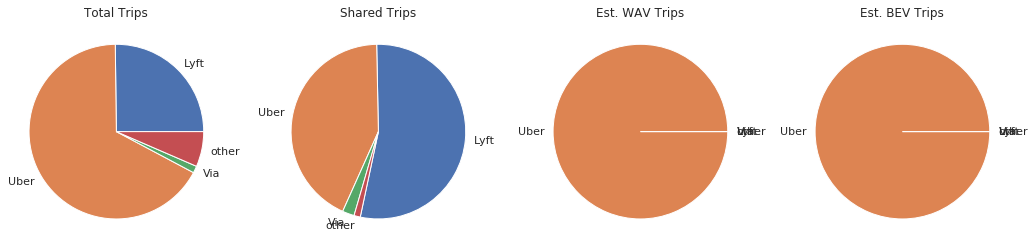

In [0]:

# Create a matplot figure with space for 4 graphs
plt.figure(figsize=(18,13))
# Size them 2 x 2
plt.subplot(1,4,1)

# Create plot 1
plt.pie(labels=week_df.index, x=week_df['trip_count'])
plt.title('Total Trips')
# Create plot 2
plt.subplot(1,4,2)
plt.pie(labels=week_df.index, x=week_df['shared'], startangle=-102)
plt.title('Shared Trips')
# Create plot 3
plt.subplot(1,4,3)
plt.pie(labels=week_df.index, x=week_df['est_WAV'])
plt.title('Est. WAV Trips')
# Create plot 4
plt.subplot(1,4,4)
plt.pie(labels=week_df.index, x=week_df['est_BEV'])
plt.title('Est. BEV Trips')

#Show plot
plt.show()

In [0]:
week_df_w_total.loc['Total'][['shared','not_shared']]


shared         17001
not_shared    108541
Name: Total, dtype: int64

## Shared Rides

Total rides

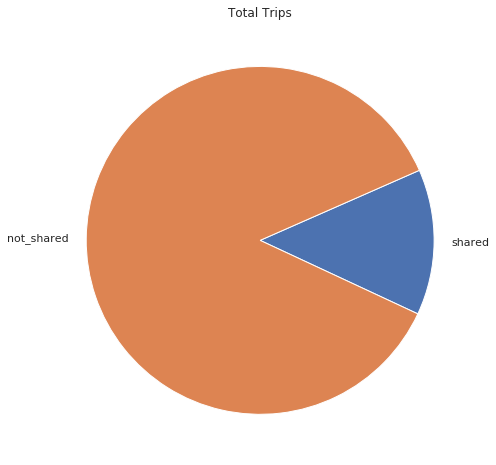

In [0]:

# Create a matplot figure with space for 4 graphs
plt.figure(figsize=(8,8))


# Create plot 1
plt.pie(labels=['shared','not_shared'], 
        x=week_df_w_total.loc['Total'][['shared','not_shared']],
        startangle=-25
        )
plt.title('Total Trips')

#Show plot
plt.show()

Per comany shared rides

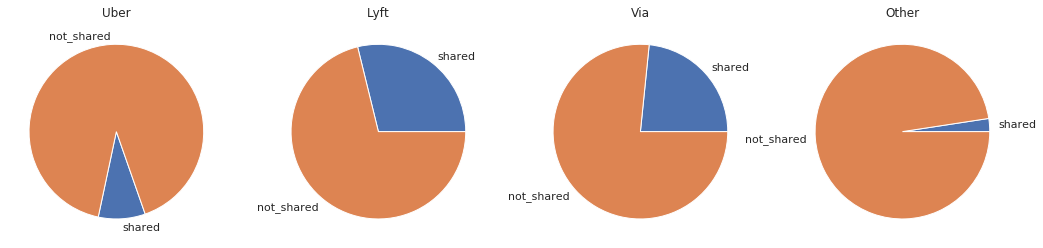

In [0]:


# Create a matplot figure with space for 4 graphs
plt.figure(figsize=(18,13))
# Size them 2 x 2
plt.subplot(1,4,1)

# Create plot 1
plt.pie(labels=['shared','not_shared'], x=week_df_w_total.loc['Uber'][['shared','not_shared']], startangle=-102)
plt.title('Uber')
# Create plot 2
plt.subplot(1,4,2)
plt.pie(labels=['shared','not_shared'], x=week_df_w_total.loc['Lyft'][['shared','not_shared']])
plt.title('Lyft')
# Create plot 3
plt.subplot(1,4,3)
plt.pie(labels=['shared','not_shared'], x=week_df_w_total.loc['Via'][['shared','not_shared']])
plt.title('Via')
# Create plot 4
plt.subplot(1,4,4)
plt.pie(labels=['shared','not_shared'], x=week_df_w_total.loc['other'][['shared','not_shared']])
plt.title('Other')

#Show plot
plt.show()


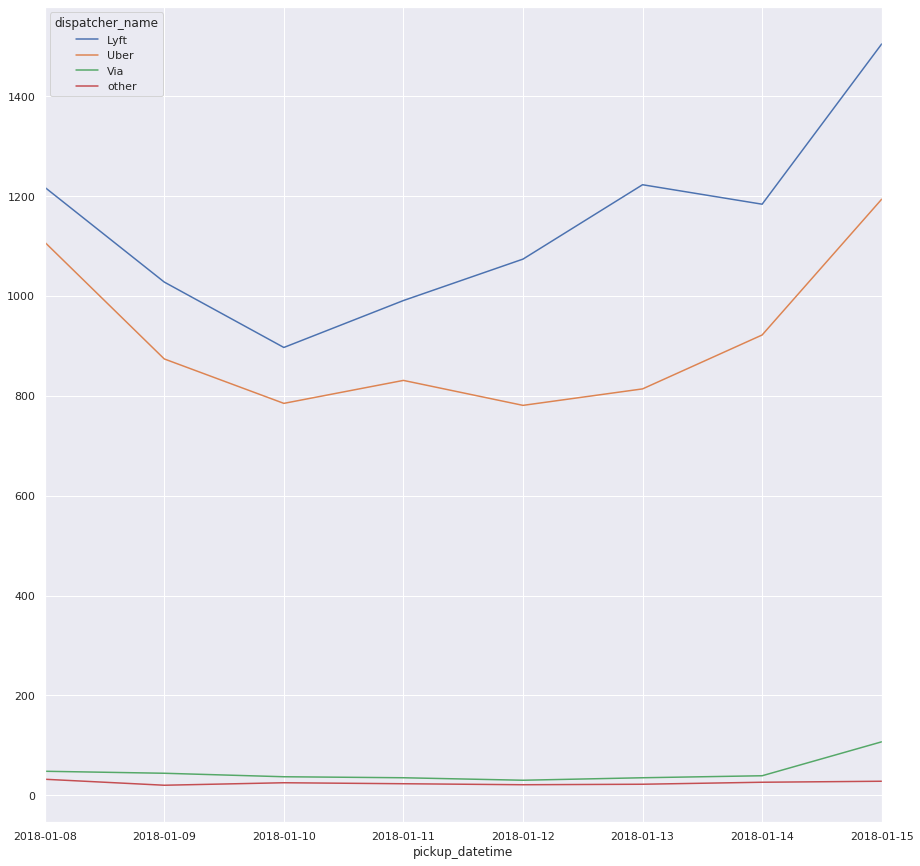

In [0]:

pv_fnl = pd.pivot_table(fnl_df.reset_index()[['pickup_datetime','dispatcher_name','shared']], index = ['pickup_datetime'], columns='dispatcher_name',values = 'shared', aggfunc=np.sum)
pv_fnl.plot.line(figsize=(15,15))

In [0]:
######## NON USED CODE #####


Non-pooling (slow) version of the above function

In [0]:
"""
# Pull out distinct vehicle types to send to nhtsa.dot.gov api to get vehicle details
# API connection at https://vpic.nhtsa.dot.gov/api/vehicles/DecodeVinValues/
import ast

def vehicle_details_retriever_no_pool(models):
  vh_dict = {}
  url1 = 'https://vpic.nhtsa.dot.gov/api/vehicles/DecodeVinValues/'
  url2 = '?format=json'

  for model in models:
 #   print("connecting to api")
    api_connect = url1 + model + url2;    # Create our api url to pull vehicle details
    r2 = requests.get(api_connect);      # Connect to api and retrieve details
    r2.json()                     # parse into json
    u = json.dumps(r2.json()['Results'])
    # Create dict of vehicle details
    dict_u = ast.literal_eval(u.replace("[","").replace("]",""))

    if 'FuelTypePrimary' in dict_u:
      x,y = dict_u['FuelTypePrimary'], dict_u['FuelTypeSecondary']
      print(model, (x,y))    # uncomment for debugging 
      vh_dict[model] = (x,y)
    else:
      print('NA')            # uncomment for debugging 
      vh_dict[model] = ('None', 'None')

  return vh_dict
  
  """



--KeyboardInterrupt--


In [0]:
"""
vh_dict_list = vehicle_details_retriever_no_pool(vh_df['vehicle_vin_number'].unique())
"""